In [1]:
import os
import random

from matplotlib import pyplot as plt
from mpl_toolkits import axes_grid1
import numpy as np

import tensorflow as tf
from tensorflow import keras

import tensorflow_similarity as tfsim

tfsim.utils.tf_cap_memory()

print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity:", tfsim.__version__)


Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


TensorFlow: 2.4.1
TensorFlow Similarity: 0.16.7


2022-08-08 11:17:11.780868: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [2]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255
)

train_generator = datagen.flow_from_directory(
    "../archive/deneme/train",
    shuffle=True,
    target_size=(224, 224),
)

valid_generator = datagen.flow_from_directory(
    "../archive/deneme/valid",
    shuffle=False,
    target_size=(224, 224),
)
x_train, y_train = next(train_generator)
x_test, y_test = next(valid_generator)


Found 4805 images belonging to 32 classes.
Found 160 images belonging to 32 classes.


In [7]:
num_known_classes = 32
class_list = random.sample(population=range(64), k=num_known_classes)

classes_per_batch = 10
# Passing multiple examples per class per batch ensures that each example has
# multiple positive pairs. This can be useful when performing triplet mining or
# when using losses like `MultiSimilarityLoss` or `CircleLoss` as these can
# take a weighted mix of all the positive pairs. In general, more examples per
# class will lead to more information for the positive pairs, while more classes
# per batch will provide more varied information in the negative pairs. However,
# the losses compute the pairwise distance between the examples in a batch so
# the upper limit of the batch size is restricted by the memory.
examples_per_class_per_batch = 8

print(" Create Training Data ".center(34, "#"))
train_ds = tfsim.samplers.MultiShotMemorySampler(
    x=x_train, y=train_generator.labels,
    classes_per_batch=min(classes_per_batch, num_known_classes),
    steps_per_epoch=4000,
    examples_per_class_per_batch=examples_per_class_per_batch,
    class_list=class_list
)

print("\n" + " Create Validation Data ".center(34, "#"))
val_ds = tfsim.samplers.MultiShotMemorySampler(
    x=x_test, y=valid_generator.labels,
    classes_per_batch=classes_per_batch,
)

###### Create Training Data ######

The initial batch size is 80 (10 classes * 8 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/32 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/32 [00:00<?, ?it/s]

gather examples:   0%|          | 0/32 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/32 [00:00<?, ?it/s]


##### Create Validation Data #####

The initial batch size is 20 (10 classes * 2 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/32 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/32 [00:00<?, ?it/s]

gather examples:   0%|          | 0/32 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/32 [00:00<?, ?it/s]

2022-08-08 11:18:05.599177: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-08 11:18:05.604389: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


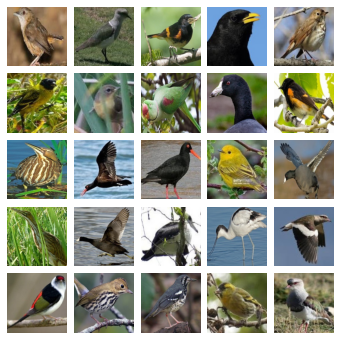

In [8]:
num_cols = num_rows = 5
# Get the first 25 examples.
x_slice, y_slice = train_ds.get_slice(begin=0, size=num_cols * num_rows)

fig = plt.figure(figsize=(6.0, 6.0))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

for ax, im, label in zip(grid, x_slice, y_slice):
    ax.imshow(im)
    ax.axis("off")

In [9]:
embedding_size = 256

inputs = keras.layers.Input((224, 224, 3))
x = keras.layers.Conv2D(64, 3, activation="relu")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, 3, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D((4, 4))(x)
x = keras.layers.Conv2D(256, 3, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(256, 3, activation="relu")(x)
x = keras.layers.GlobalMaxPool2D()(x)
outputs = tfsim.layers.MetricEmbedding(embedding_size)(x)

# building model
model = tfsim.models.SimilarityModel(inputs, outputs)
model.summary()

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 128)     73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 220, 220, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 256)  

In [10]:
from keras.callbacks import ModelCheckpoint
import os

epochs = 5
learning_rate = 0.002
val_steps = 50

# init similarity loss
loss = tfsim.losses.MultiSimilarityLoss()

# compiling and training
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate), loss=loss
)
pathdir = "../savedModels/"
checkpoint = ModelCheckpoint(filepath=os.path.join(pathdir),
                             save_best_only=True,
                             monitor="loss",
                             mode="max",
                             verbose=1
                             )
history = model.fit(
    train_ds, epochs=epochs, validation_data=val_ds, validation_steps=val_steps
    , callbacks=[checkpoint]
)

Distance metric automatically set to cosine use the distance arg to override.


Using TensorFlow backend.


IndexError: list index out of range